In [13]:
import numpy as np
import pandas as pd
import EA_funcs as ea
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
np.random.seed(62)

# Evolutionary Algorithm test

In [5]:
test = ea.EA(top_closing_prices, pop_size=100, lambda_=600, p_m=0.1, max_w=0.1)
test.pop_fitness.max()

0.13941943903466888

In [6]:
test.run(100)
test.pop_fitness.max()

0.19609660733703066

In [7]:
x = np.argmax(test.pop_fitness)
best = test.population[x,:-1]
test.fitness(best)

(0.19609660733703066, 0.519097834268873, 12.69046195948117)

In [8]:
print('sum of genes in best solution: ', best.sum())
print(f"all of best solution's genes < {test.max_w} :", np.all(best<test.max_w))
print('sum of all genes in population: ', test.population[:,:-1].sum(),
                                                  f'(pop size={test.pop_size})')
print(f"all population's genes < {test.max_w}: ",
                                             np.all(test.population[:, :-1]<=test.max_w))
print(f"no negative weights in the population:", np.all(test.population>=0))

sum of genes in best solution:  1.0
all of best solution's genes < 0.1 : True
sum of all genes in population:  100.0 (pop size=100)
all population's genes < 0.1:  True
no negative weights in the population: True


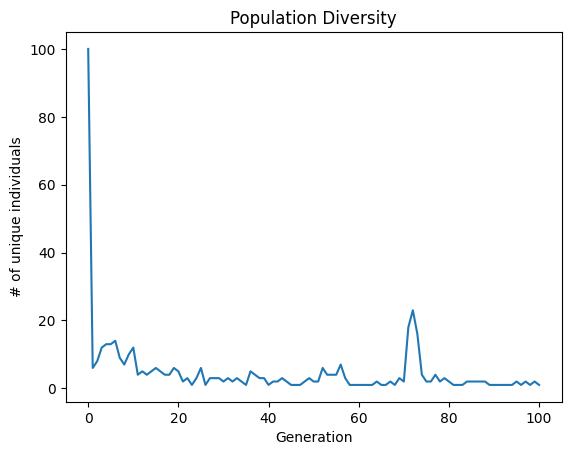

In [9]:
test.plot_diversity()

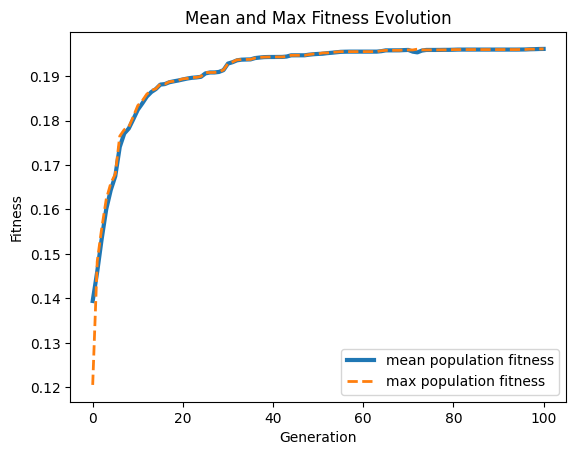

In [10]:
test.plot_fitness()

# Performance

### MBF (mean best fitness)

In [ ]:
best_fits, best_returns, risks = ea.MBF(ea.EA, top_closing_prices, p_m=0.1, max_w=0.4, delta=0.5)
print(best_returns.min(), best_returns.max(), best_returns.std())
print(risks.min(), risks.max(), risks.std())

### AES (Average fitness Evaluations to Solution) + SR (Success Rate)

In [ ]:
evals, returns, risks = ea.AES_SR(ea.EA, top_closing_prices, solution=0.45, max_w=0.4, p_m=0.1, delta=0.4)

In [ ]:
data = {"Evaluations": evals, "Expected returns": returns, "Risk": risks}

results = pd.DataFrame(data).sort_values("Expected returns", ascending=False)
results

In [ ]:
sns.scatterplot(results, "Expected returns", "Risk")

In [ ]:
results.describe().loc[["min", "max", "mean", "std"]]

In [ ]:
np.nanstd(evals)

In [ ]:
evals

### Robustness

In [ ]:
ea.all_data.shape

# PRUEBAS




In [ ]:
ranking = ea.anual_returns/ea.risks
ranked = ranking.sort_values(ascending=False).index

ranked_data = ea.all_data[ranked]

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(8, 8), sharey=True, sharex=True)
axs_i = [[0, 0], [0, 1], [1, 0], [1, 1]]
n_assets = [398, 250, 100, 50]
w_start = [0.005, 0.01, 0.02, 0.04]
for i, n in enumerate(n_assets):
    returns = []
    risks = []
    ws = np.linspace(w_start[i], 0.1, 10)
    sample = ranked_data.iloc[:, :n_assets[i]]
    for w in ws:
        EA = ea.EA(sample, max_w=w)
        EA.run(25)
        best = EA.population[np.argmax(EA.pop_fitness)][:-1]
        _, returns_, risk = EA.fitness(best)
        returns.append(returns_)
        risks.append(risk)
    ax = axs[axs_i[i][0], axs_i[i][1]]
    scatter = ax.scatter(risks, returns, c=ws, cmap='viridis', s=30)
    cbar = fig.colorbar(scatter, ax=ax)
    ax.set_title(f'{n} Activos')
    ax.set_xticks([0, 0.1, 0.2, 0.3, 0.4, 0.5])
    ax.vlines(0.2, 0, 0.7, color='r', linestyles=':')
plt.suptitle('Efecto del Grado de Diversificación \nde la Cartera')
axs[1, 0].set_xlabel('Riesgo')
axs[1, 1].set_xlabel('Riesgo')
axs[0, 0].set_ylabel('Retorno Esperado')
axs[1, 0].set_ylabel('Retorno Esperado')
plt.tight_layout()
plt.savefig('fit_vs_risk_vs_maxw.jpg')

## MBF para distintos datasets

### Muestreo Determinista:

In [ ]:
n_assets = [398, 250, 100, 50]
mbfs = np.empty(len(max_w))
for i, n in enumerate(n_assets):
    assets = ranked_data.iloc[:, :n]
    mbf = MBF(EA, assets, runs=10, generations=50, max_w=0.07).mean()
    mbfs[i] = mbf

deterministic_mbf_comparison = pd.DataFrame(mbfs, n_assets)
deterministic_mbf_comparison

### Muestreo Aleatorio

In [ ]:
mbfs = np.empty(len(n_assets))
for i, n in enumerate(n_assets):
    assets = all_data.sample(n, axis=1)
    mbf = MBF(EA, assets, runs=10, generations=50, max_w=0.07).mean()
    mbfs[i] = mbf

random_mbf_comparison = pd.DataFrame(mbfs, n_assets)
random_mbf_comparison

# Evolución del fitness para distintos valores de k (rho en el código)

In [ ]:
best100 = ranked_data.iloc[:, :100]

In [ ]:
ks = [0, 0.2, 0.4, 0.5, 0.6, 0.8, 1]
for k in ks:
    ea = EA(best100, delta=k, max_w=0.07, pop_size=1000, lambda_=6000)
    ea.run(10)
    ea.plot_max_fitness(label=f'{k}')
plt.legend(bbox_to_anchor=(1, 1.02), title=r'$\delta$')

plt.title('Evolución de Aptitud Máxima')
plt.xlabel('Generación')
plt.tight_layout()
plt.savefig('Evolucion_de_fitness_segun_k.jpg')
files.download("Evolucion_de_fitness_segun_k.jpg")

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(7, 4))
ks = [0, 0.2, 0.4, 0.5, 0.6, 0.8, 1]
for k in ks:
    ea = EA(best100, delta=k, max_w=0.07)
    returns = []
    risks = []
    for i in range(50):
        ea.run(1)
        best = ea.population[np.argmax(ea.pop_fitness)][:-1]
        _, r, risk = ea.fitness(best)
        returns.append(r)
        risks.append(risk)
    ax[0].plot(returns)
    ax[1].plot(risks, label=k)
plt.legend(bbox_to_anchor=(1, 1.02), title=r'$\delta$')
ax[0].set_ylabel('Retorno Esperado')
ax[1].set_ylabel('Riesgo')
ax[0].set_xlabel('Generación')
ax[1].set_xlabel('Generación')
ax[0].set_title('Evolución de Retorno Esperado')
ax[1].set_title('Evolución del Riesgo')
plt.tight_layout()
plt.savefig('Evolucion_de_retorno_segun_delta.jpg')
files.download('Evolucion_de_retorno_segun_delta.jpg')

### MBF para distintos k.

In [ ]:
ks = np.linspace(0, 1, 11)
mbfs = np.empty(ks.shape)
for i, k in enumerate(ks):
    mbf = MBF(EA, best100, runs=5, delta=k, max_w=0.07).mean()
    mbfs[i] = mbf

plt.plot(ks, mbfs)
plt.xlabel(r'$\delta$')
plt.ylabel('MBF')
plt.title('MBF Según la Tolerancia al Riesgo')
plt.savefig('MBF_vs_delta.jpg')
files.download("MBF_vs_delta.jpg")

### Fitness vs. Riesgo para distintas k

In [ ]:
ks = np.linspace(0, 1, 11)
returns = np.empty(ks.shape)
risks = np.empty(ks.shape)
for i, k in enumerate(ks):
    ea = EA(best100, rho=k, max_w=0.07)
    ea.run(50)
    best = ea.population[np.argmax(ea.pop_fitness)][:-1]
    _, r, risk = ea.fitness(best)
    returns[i] = r
    risks[i] = risk

plt.plot(risks, returns, ':')
sns.scatterplot(x=risks, y=returns, hue=ks, palette='viridis', s=80)
plt.xlabel('Riesgo')
plt.ylabel('Retorno Esperado')
plt.title('Retorno Esperado vs. Riesgo de la Cartera \npara Distintos Valores de $k$')
plt.savefig('fit_vs_risk_vs_k.jpg')
files.download('fit_vs_risk_vs_k.jpg')

### Evolución de diversidad para distintas tasas de mutación ($p_m$)

In [ ]:
pm = [0.0001, 0.005, 0.01, 0.02, 0.05, 0.2]

for i, p in enumerate(pm):
    ea = EA(best100, max_w=0.07, p_m = p)
    ea.run(50)
    fit = ea.max_fit_history
    gens = range(len(fit))
    plt.plot(gens, fit, label=p)
plt.xlabel('Generación')
plt.ylabel('Fitness')
plt.legend(bbox_to_anchor=(1, 1.02), title=r'$p_m$')
plt.suptitle('Fitness para Distintas Tasas de Mutación')
plt.tight_layout()
plt.savefig('fitness_vs_pm.jpg')
files.download('fitness_vs_pm.jpg')

# Pruebas de Robustez

### Respecto a diferentes activos

In [ ]:
fits = asset_robustness(data=all_data, sample_size=100, pop_size=1000,
                        lambda_=6000, generations=50, max_w=0.07, p_m=0.05)
plt.title('Prueba de Robustez para Distintos Grupos de Activos')
plt.xlabel('Generación')
plt.tight_layout()
plt.savefig('asset_robustness.jpg')
files.download('asset_robustness.jpg')
fits

### Respecto a distintos periodos de tiempo

In [ ]:
fits = time_robustness(data=all_data, periods=6, pop_size=1000,
                        lambda_=6000, generations=50, max_w=0.07, p_m=0.05)
plt.title('Prueba de Robustez para Distintos Periodos de Tiempo')
plt.xlabel('Generación')
plt.tight_layout()
plt.savefig('time_robustness.jpg')
files.download('time_robustness.jpg')
fits

In [ ]:
best_fits = []
ps = [10, 25, 50, 100, 250, 500, 1000]
for p in ps:
    ea = EA(best100, pop_size=p, lambda_=6*p, p_m=0.05, max_w=0.07,
            testing=False)
    ea.run(int(100/np.log10(p)))
    print(p, 'done')
    best_fits.append(ea.pop_fitness.max())
plt.plot(ps, best_fits)
plt.title(r'Fitness Máximo vs. $\mu$')
plt.xscale('log')
plt.xlabel(r'$\mu$')
plt.ylabel('Fitness')
plt.tight_layout()
plt.savefig('fit_vs_pop_size.jpg')
files.download('fit_vs_pop_size.jpg')

In [ ]:
fits1, returns1, risks1 = MBF(EA, best100, p_m=0.05, max_w=0.07, pop_size=1000,
                           delta=0.51, lambda_=6000, runs=10, generations=50)

In [ ]:
returns1.mean(), returns1.std()

In [ ]:
risks1.mean(), risks1.std()

In [ ]:
evals2, returns2, risks2 = AES_SR(EA, best100, solution=0.208, max_risk=0.181,
                               max_gens=50, p_m=0.05, max_w=0.07, delta=0.51,
                               pop_size=1000, lambda_=6000, runs=30)

In [ ]:
plt.scatter(risks2, returns2)
plt.xlabel('Riesgo')
plt.ylabel('Retorno Esperado')
plt.title('Resultados de la Prueba de Desempeño')
plt.tight_layout()
plt.savefig('resultados.jpg')
files.download('resultados.jpg')

In [ ]:
test = EA(best100, p_m=0.05, max_w=0.07, pop_size=2000, lambda_=12000, delta=0.51)
best = test.population[np.argmax(test.pop_fitness)][:-1]
test.fitness(best)

In [ ]:
test.run(1)

In [ ]:
best = test.population[np.argmax(test.pop_fitness)][:-1]
test.fitness(best)

In [ ]:
test.plot_fitness()
plt.xlabel('Generación')
plt.title('Fitness Medio y Máximo por Generación')
plt.legend(labels=['Fitness promedio', 'Fitness Máximo'])
plt.tight_layout()
plt.savefig('ejemplo.jpg')
files.download('ejemplo.jpg')

In [ ]:
test.plot_diversity()
plt.yscale('log')
plt.xlabel('Generación')
plt.ylabel('# de individuos distintos')
plt.title('Evolución de la Diversidad de la Población')
plt.tight_layout()
plt.savefig('diversidad.jpg')
files.download('diversidad.jpg')

In [ ]:
test.portfolio().T

In [ ]:
best100.columns